In [2]:
import pandas as pd
import numpy as np
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [3]:
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\DATA SCIENCE\Datasets\PEL.NS.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,31-08-2020,1517.099976,1530.000000,1360.099976,1367.300049,1271.142334,3325380
1,01-09-2020,1380.000000,1407.099976,1303.550049,1355.900024,1260.544067,3405979
2,02-09-2020,1365.000000,1377.400024,1321.199951,1354.599976,1259.335571,1429113
3,03-09-2020,1354.599976,1374.949951,1337.000000,1349.699951,1254.780151,1378851
4,04-09-2020,1327.300049,1333.099976,1274.050049,1292.400024,1201.509888,2194293


In [4]:
# convert date field from string to Date format and make it index
df['DATE'] = pd.to_datetime(df.Date, dayfirst=True)
df['DATE'] = pd.to_datetime(df.Date, format='%d-%m-%Y')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,DATE
0,31-08-2020,1517.099976,1530.000000,1360.099976,1367.300049,1271.142334,3325380,2020-08-31
1,01-09-2020,1380.000000,1407.099976,1303.550049,1355.900024,1260.544067,3405979,2020-09-01
2,02-09-2020,1365.000000,1377.400024,1321.199951,1354.599976,1259.335571,1429113,2020-09-02
3,03-09-2020,1354.599976,1374.949951,1337.000000,1349.699951,1254.780151,1378851,2020-09-03
4,04-09-2020,1327.300049,1333.099976,1274.050049,1292.400024,1201.509888,2194293,2020-09-04


In [5]:
df.sort_values(by='DATE', inplace=True)
df.head()
df.shape

(745, 8)

In [6]:
# Duration of the dataset
print("Starting date: ",df.iloc[0][7])
print("Ending date: ", df.iloc[-1][7])
print("Duration: ", df.iloc[-1][7]-df.iloc[0][7])

Starting date:  2020-08-31 00:00:00
Ending date:  2023-08-29 00:00:00
Duration:  1093 days 00:00:00


In [7]:
# Normalizing / scaling close value between 0 to 1
closedf = df[['DATE','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (745, 2)


In [8]:
close_stock = closedf.copy()
del closedf['DATE']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(745, 1)


In [9]:
# Split data for training and testing. Ratio for training and testing data is 65:35
training_size=int(len(closedf)*0.65)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (484, 1)
test_data:  (261, 1)


In [105]:
# Create new dataset according to requirement of time-series prediction

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (468, 15)
y_train:  (468,)
X_test:  (245, 15)
y_test (245,)


In [106]:
# LSTM
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (468, 15, 1)
X_test:  (245, 15, 1)


In [108]:
# from sklearn.model_selection import TimeSeriesSplit

# Define the cross-validator
# tscv = TimeSeriesSplit(n_splits=5)

# Assuming 'X' is your features and 'y' is the target variable
# for train_index, test_index in tscv.split(X_train):
  #  X_train_1, X_test_1 = X_train[train_index], X_train[test_index]
   # y_train_1, y_test_1 = y_train[train_index], y_train[test_index]

#print("X_train_split: ", X_train_1.shape)
#print("X_test_split: ", X_test_1.shape)    

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (468, 15, 1)
X_test:  (245, 15, 1)


In [109]:
# LSTM model structure
tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [117]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=400,batch_size=5,verbose=1)

Epoch 1/400
94/94 [==============================] - 7s 27ms/step - loss: 0.0201 - val_loss: 0.0051
Epoch 2/400
94/94 [==============================] - 2s 18ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 3/400
94/94 [==============================] - 2s 18ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 4/400
94/94 [==============================] - 2s 19ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 5/400
94/94 [==============================] - 2s 19ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 6/400
94/94 [==============================] - 2s 18ms/step - loss: 0.0036 - val_loss: 0.0068
Epoch 7/400
94/94 [==============================] - 2s 18ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 8/400
94/94 [==============================] - 2s 19ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 9/400
94/94 [==============================] - 2s 18ms/step - loss: 0.0030 - val_loss: 0.0058
Epoch 10/400
94/94 [==============================] - 2s 19ms/step - loss: 0.0028 - val_loss: 0.0037

Epoch 79/400
94/94 [==============================] - 2s 16ms/step - loss: 6.5766e-04 - val_loss: 0.0020
Epoch 80/400
94/94 [==============================] - 2s 16ms/step - loss: 7.7705e-04 - val_loss: 0.0012
Epoch 81/400
94/94 [==============================] - 2s 17ms/step - loss: 7.2683e-04 - val_loss: 9.5802e-04
Epoch 82/400
94/94 [==============================] - 2s 16ms/step - loss: 6.3125e-04 - val_loss: 0.0021
Epoch 83/400
94/94 [==============================] - 2s 16ms/step - loss: 6.6386e-04 - val_loss: 0.0025
Epoch 84/400
94/94 [==============================] - 2s 16ms/step - loss: 6.9056e-04 - val_loss: 0.0018
Epoch 85/400
94/94 [==============================] - 2s 16ms/step - loss: 7.0236e-04 - val_loss: 0.0012
Epoch 86/400
94/94 [==============================] - 2s 16ms/step - loss: 6.4389e-04 - val_loss: 0.0021
Epoch 87/400
94/94 [==============================] - 2s 16ms/step - loss: 6.2854e-04 - val_loss: 0.0015
Epoch 88/400
94/94 [==============================]

94/94 [==============================] - 2s 16ms/step - loss: 5.7830e-04 - val_loss: 0.0011
Epoch 157/400
94/94 [==============================] - 2s 16ms/step - loss: 5.7643e-04 - val_loss: 0.0011
Epoch 158/400
94/94 [==============================] - 2s 16ms/step - loss: 5.9476e-04 - val_loss: 0.0018
Epoch 159/400
94/94 [==============================] - 2s 16ms/step - loss: 5.9007e-04 - val_loss: 0.0016
Epoch 160/400
94/94 [==============================] - 2s 16ms/step - loss: 6.9540e-04 - val_loss: 7.3763e-04
Epoch 161/400
94/94 [==============================] - 2s 17ms/step - loss: 6.4632e-04 - val_loss: 0.0028
Epoch 162/400
94/94 [==============================] - 2s 16ms/step - loss: 6.3975e-04 - val_loss: 0.0010
Epoch 163/400
94/94 [==============================] - 2s 16ms/step - loss: 6.0084e-04 - val_loss: 0.0010
Epoch 164/400
94/94 [==============================] - 2s 16ms/step - loss: 6.1228e-04 - val_loss: 0.0014
Epoch 165/400
94/94 [==============================] - 2

Epoch 232/400
94/94 [==============================] - 2s 16ms/step - loss: 6.0345e-04 - val_loss: 7.9371e-04
Epoch 233/400
94/94 [==============================] - 2s 16ms/step - loss: 6.3011e-04 - val_loss: 6.5602e-04
Epoch 234/400
94/94 [==============================] - 2s 16ms/step - loss: 6.0856e-04 - val_loss: 5.5672e-04
Epoch 235/400
94/94 [==============================] - 2s 16ms/step - loss: 5.6664e-04 - val_loss: 5.1664e-04
Epoch 236/400
94/94 [==============================] - 2s 16ms/step - loss: 5.9672e-04 - val_loss: 3.7549e-04
Epoch 237/400
94/94 [==============================] - 2s 16ms/step - loss: 6.1565e-04 - val_loss: 4.3217e-04
Epoch 238/400
94/94 [==============================] - 2s 16ms/step - loss: 6.1707e-04 - val_loss: 3.5095e-04
Epoch 239/400
94/94 [==============================] - 2s 16ms/step - loss: 5.8274e-04 - val_loss: 4.4679e-04
Epoch 240/400
94/94 [==============================] - 2s 16ms/step - loss: 6.4456e-04 - val_loss: 4.8793e-04
Epoch 241/

Epoch 307/400
94/94 [==============================] - 2s 17ms/step - loss: 5.8146e-04 - val_loss: 8.2860e-04
Epoch 308/400
94/94 [==============================] - 2s 20ms/step - loss: 6.1108e-04 - val_loss: 9.2454e-04
Epoch 309/400
94/94 [==============================] - 2s 21ms/step - loss: 5.8353e-04 - val_loss: 6.1049e-04
Epoch 310/400
94/94 [==============================] - 2s 17ms/step - loss: 5.9770e-04 - val_loss: 6.5113e-04
Epoch 311/400
94/94 [==============================] - 2s 17ms/step - loss: 5.5205e-04 - val_loss: 6.7930e-04
Epoch 312/400
94/94 [==============================] - 2s 16ms/step - loss: 6.0490e-04 - val_loss: 5.1611e-04
Epoch 313/400
94/94 [==============================] - 1s 16ms/step - loss: 5.9998e-04 - val_loss: 5.8400e-04
Epoch 314/400
94/94 [==============================] - 2s 17ms/step - loss: 6.0717e-04 - val_loss: 7.4508e-04
Epoch 315/400
94/94 [==============================] - 2s 17ms/step - loss: 6.4068e-04 - val_loss: 6.2650e-04
Epoch 316/

94/94 [==============================] - 2s 17ms/step - loss: 6.0053e-04 - val_loss: 0.0012
Epoch 383/400
94/94 [==============================] - 2s 17ms/step - loss: 5.5473e-04 - val_loss: 8.7483e-04
Epoch 384/400
94/94 [==============================] - 2s 17ms/step - loss: 5.5398e-04 - val_loss: 0.0021
Epoch 385/400
94/94 [==============================] - 2s 17ms/step - loss: 6.2159e-04 - val_loss: 0.0014
Epoch 386/400
94/94 [==============================] - 2s 17ms/step - loss: 6.4372e-04 - val_loss: 0.0015
Epoch 387/400
94/94 [==============================] - 2s 16ms/step - loss: 5.9747e-04 - val_loss: 0.0011
Epoch 388/400
94/94 [==============================] - 2s 17ms/step - loss: 5.7258e-04 - val_loss: 0.0015
Epoch 389/400
94/94 [==============================] - 2s 17ms/step - loss: 5.7104e-04 - val_loss: 7.5893e-04
Epoch 390/400
94/94 [==============================] - 2s 16ms/step - loss: 6.0153e-04 - val_loss: 0.0012
Epoch 391/400
94/94 [==============================]

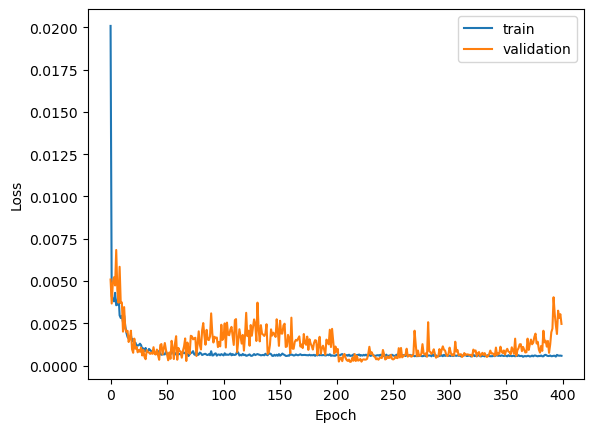

In [118]:
import matplotlib.pyplot as plt

# Plot training error
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [119]:
# Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

8/8 [==============================] - 0s 8ms/step


((468, 1), (245, 1))

In [120]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [121]:
# Evaluation metrices RMSE, MSE and MAE
# Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data RMSE:  51.49386095353238
Train data MSE:  2651.617715901727
Test data MAE:  37.60649045304154
-------------------------------------------------------------------------------------
Test data RMSE:  113.65917088465203
Test data MSE:  12918.40712618653
Test data MAE:  94.69903311216518
Train data explained variance regression score: 0.9879945011746942
Test data explained variance regression score: 0.613323432804412


In [122]:
# R2 score for regression
# R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9879939558444302
Test data R2 score: -0.1788940257926559


In [123]:
# Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0006608351675967405
Test data MGD:  0.015823542399396182
----------------------------------------------------------------------
Train data MPD:  1.2926910603771016
Test data MPD:  14.117632231940973


In [124]:
# Comparision between original stock close price vs predicted close price

# shift train predictions for plotting
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['DATE'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (745, 1)
Test predicted data:  (745, 1)


In [125]:
# Predicting next 10 days
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [126]:
    # Plotting last 15 days and next predicted 10 days
    last_days=np.arange(1,time_step+1)
    day_pred=np.arange(time_step+1,time_step+pred_days+1)
    print(last_days)
    print(day_pred)

    temp_mat = np.empty((len(last_days)+pred_days+1,1))
    temp_mat[:] = np.nan
    temp_mat = temp_mat.reshape(1,-1).tolist()[0]

    last_original_days_value = temp_mat
    next_predicted_days_value = temp_mat

    last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
    next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

    new_pred_plot = pd.DataFrame({
        'last_original_days_value':last_original_days_value,
        'next_predicted_days_value':next_predicted_days_value
    })

    names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

    fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                          new_pred_plot['next_predicted_days_value']],
                  labels={'value': 'Stock price','index': 'Timestamp'})
    fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                      plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
    
 # Prepare the text for the annotation
predicted_prices_text = "\n".join([f"Day {i+1}: {price:.2f}" for i, price in enumerate(next_predicted_days_value[time_step+1:])])
annotation_text = f"Predicted Prices for Next 10 Days:\n{predicted_prices_text}"

    fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [127]:
import pandas as pd
import numpy as np
from itertools import cycle
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Your Data Preparation Code
last_days = np.arange(1, time_step+1)
day_pred = np.arange(time_step+1, time_step+pred_days+1)

temp_mat = np.empty((len(last_days)+pred_days+1, 1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1, -1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1, -1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)).reshape(1, -1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value': last_original_days_value,
    'next_predicted_days_value': next_predicted_days_value
})

# Creating subplot with 2 rows
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.05,
                    row_heights=[0.8, 0.1],
                    subplot_titles=('Compare last 15 days vs next 10 days', 'Predicted Prices for Next 10 Days'))

# Adding traces for actual and predicted stock prices
fig.add_trace(go.Scatter(x=new_pred_plot.index, y=new_pred_plot['last_original_days_value'], name='Last 15 days close price'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=new_pred_plot.index, y=new_pred_plot['next_predicted_days_value'], name='Predicted next 10 days close price'),
              row=1, col=1)

# Annotations for predicted prices in the bottom part
y_pos = 0.5  # Starting y-position
y_step = 1.0 / len(next_predicted_days_value[time_step+1:])  # Determine the step for each annotation

for i, price in enumerate(next_predicted_days_value[time_step+1:]):
    fig.add_annotation(dict(font=dict(color="black",size=12),
                            x=1.05,
                            y=y_pos,
                            showarrow=False,
                            text=f"Day {i+1}: {price:.2f}",
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))
    y_pos -= y_step  # Move the y-position for the next annotation

fig.update_layout(title_text='Stock Price Predictions',
                  plot_bgcolor='white', font_size=15, font_color='black')

fig.update_xaxes(showgrid=False, row=1, col=1)
fig.update_yaxes(showgrid=False, row=1, col=1)
fig.update_yaxes(showgrid=False, showticklabels=False, zeroline=False, row=2, col=1)

fig.show()


In [128]:
# Plotting whole closing stock price with prediction

lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()